In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 25
CHANNELS = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../Dataset/isPata",
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
)

Found 20760 files belonging to 4 classes.


In [4]:
for image_batch, labels_batch in dataset.take(3):
    print(image_batch.shape)
    print(labels_batch)

(32, 256, 256, 3)
tf.Tensor([1 3 3 3 3 3 2 3 1 3 3 3 3 3 3 3 3 3 2 2 3 1 3 3 3 3 3 2 3 3 1 3], shape=(32,), dtype=int32)
(32, 256, 256, 3)
tf.Tensor([3 3 3 3 2 3 3 3 2 3 3 2 3 3 3 1 2 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3], shape=(32,), dtype=int32)
(32, 256, 256, 3)
tf.Tensor([1 0 3 3 3 2 3 3 3 3 2 3 3 2 3 3 3 1 3 3 3 1 3 2 3 3 3 3 2 2 3 3], shape=(32,), dtype=int32)


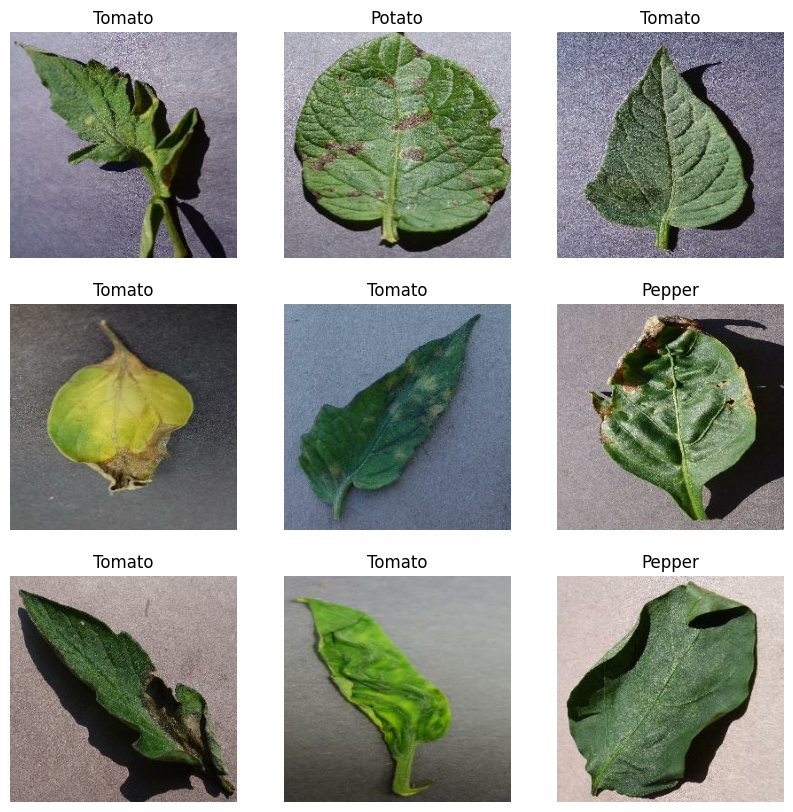

In [5]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.shuffle(15).take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(dataset.class_names[int(labels_batch[i])])
        plt.axis("off")

In [6]:
def getTrainValTest(
    dataset, train_percent, val_percent, test_percent, shuffle=True, shuffle_size=10000
):
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, reshuffle_each_iteration=False)

    train_size = int(len(dataset) * train_percent)
    val_size = int(len(dataset) * val_percent)
    test_size = int(len(dataset) * test_percent)
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size + val_size).take(test_size)
    return train_dataset, val_dataset, test_dataset

In [7]:
train_dataset, val_dataset, test_dataset = getTrainValTest(dataset, 0.7, 0.15, 0.15)

In [8]:
train_dataset = (
    train_dataset.cache()
    .shuffle(1000)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)
val_dataset = (
    val_dataset.cache()
    .shuffle(1000)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)
test_dataset = (
    test_dataset.cache()
    .shuffle(1000)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

In [9]:
resize_and_rescale = tf.keras.Sequential(
    [layers.Resizing(IMAGE_SIZE, IMAGE_SIZE), layers.Rescaling(1.0 / 255)]
)

In [10]:
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

In [11]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(dataset.class_names)

model = models.Sequential(
    [
        resize_and_rescale,
        data_augmentation,
        layers.Conv2D(32, (3, 3), input_shape=input_shape, activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(n_classes, activation="softmax"),
    ]
)

model.build(input_shape)

d:\Projects\plant-aid-server\.plant-aid\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 12544)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 4)                │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,388 (3.42 MB)

 Trainable params: 896,388 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    verbose=1,
    batch_size=BATCH_SIZE,
)

Epoch 1/25


454/454 ━━━━━━━━━━━━━━━━━━━━ 1609s 3s/step - accuracy: 0.8057 - loss: 0.5714 - val_accuracy: 0.8805 - val_loss: 0.3478
Epoch 2/25
131/454 ━━━━━━━━━━━━━━━━━━━━ 16:24 3s/step - accuracy: 0.8851 - loss: 0.3237

In [28]:
scores = model.evaluate(test_dataset)

97/97 ━━━━━━━━━━━━━━━━━━━━ 66s 683ms/step - accuracy: 0.9942 - loss: 0.0153


In [29]:
scores

[0.0161113403737545, 0.9935566782951355]

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 454}

In [32]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [20]:
acc = history.history["accuracy"]
loss = history.history["loss"]
val_accuracy = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

Text(0.5, 1.0, 'Training and validation accuracy')

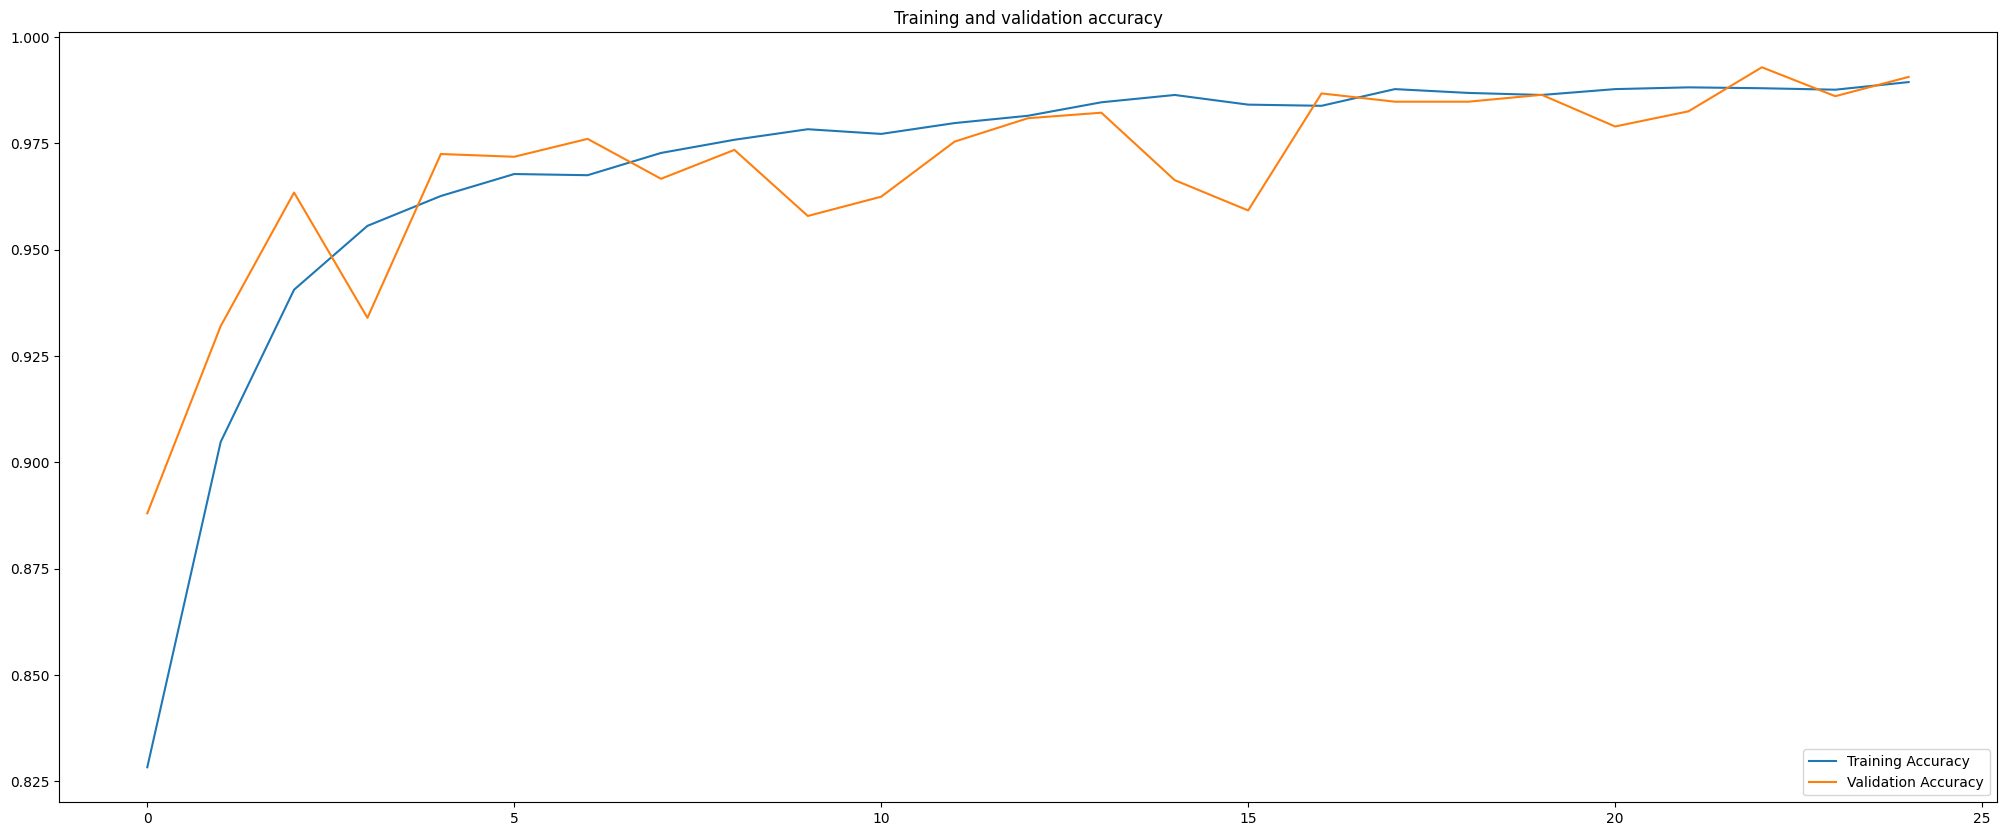

In [33]:
plt.figure(figsize=(25, 10))
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_accuracy, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and validation accuracy")

Text(0.5, 1.0, 'Training and Validation Loss')

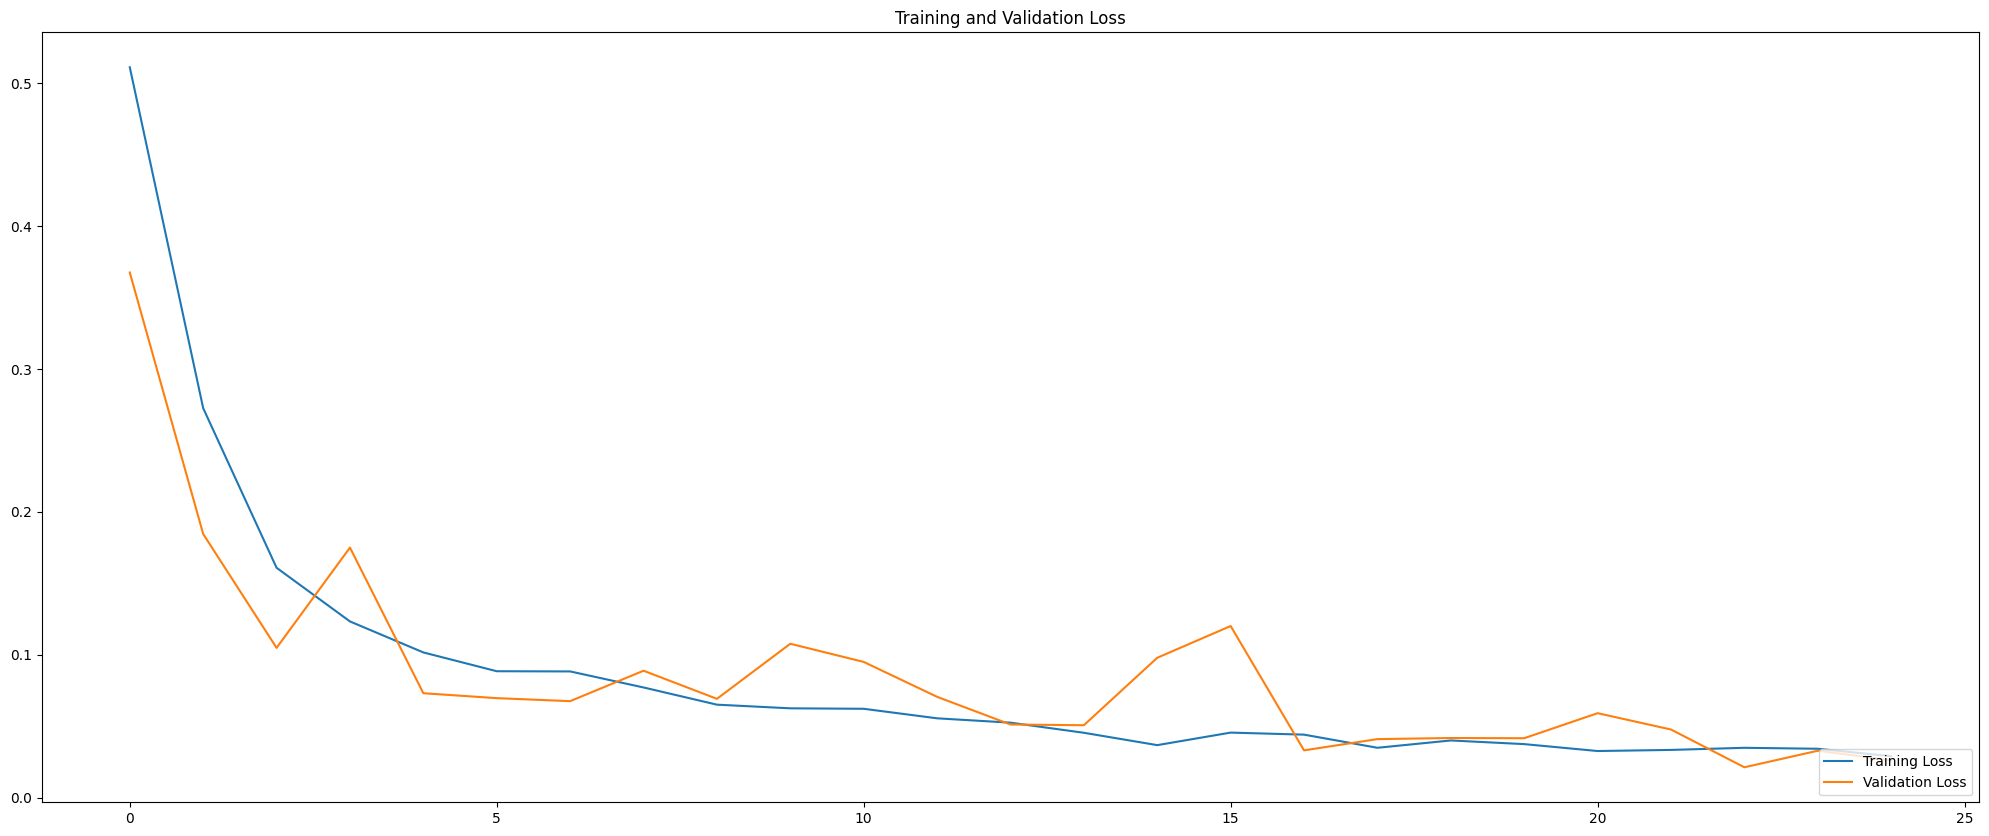

In [34]:
plt.figure(figsize=(25, 10))
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend(loc="lower right")
plt.title("Training and Validation Loss")

First Image to predict
Actual label: Tomato
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
Predicted label: Tomato


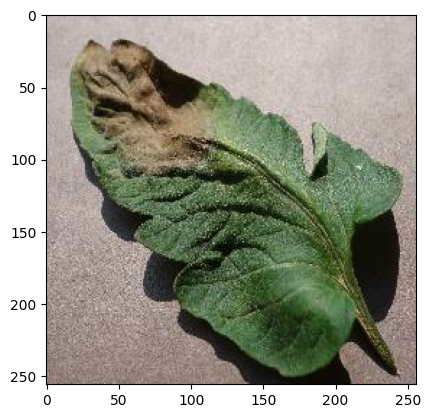

In [35]:
for image_batch, labels_batch in test_dataset.take(1):
    first_image = image_batch[20].numpy().astype("uint8")
    first_label = labels_batch[20].numpy()
    print("First Image to predict")
    plt.imshow(first_image)
    print("Actual label:", dataset.class_names[first_label])
    batch_prediction = model.predict(image_batch)
    print("Predicted label:", dataset.class_names[batch_prediction[0].argmax()])

In [36]:
def predic_img(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = dataset.class_names[predictions[0].argmax()]
    confidence = predictions[0][predictions[0].argmax()]
    return predicted_class, confidence

In [37]:
dataset.class_names

['Others', 'Pepper', 'Potato', 'Tomato']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


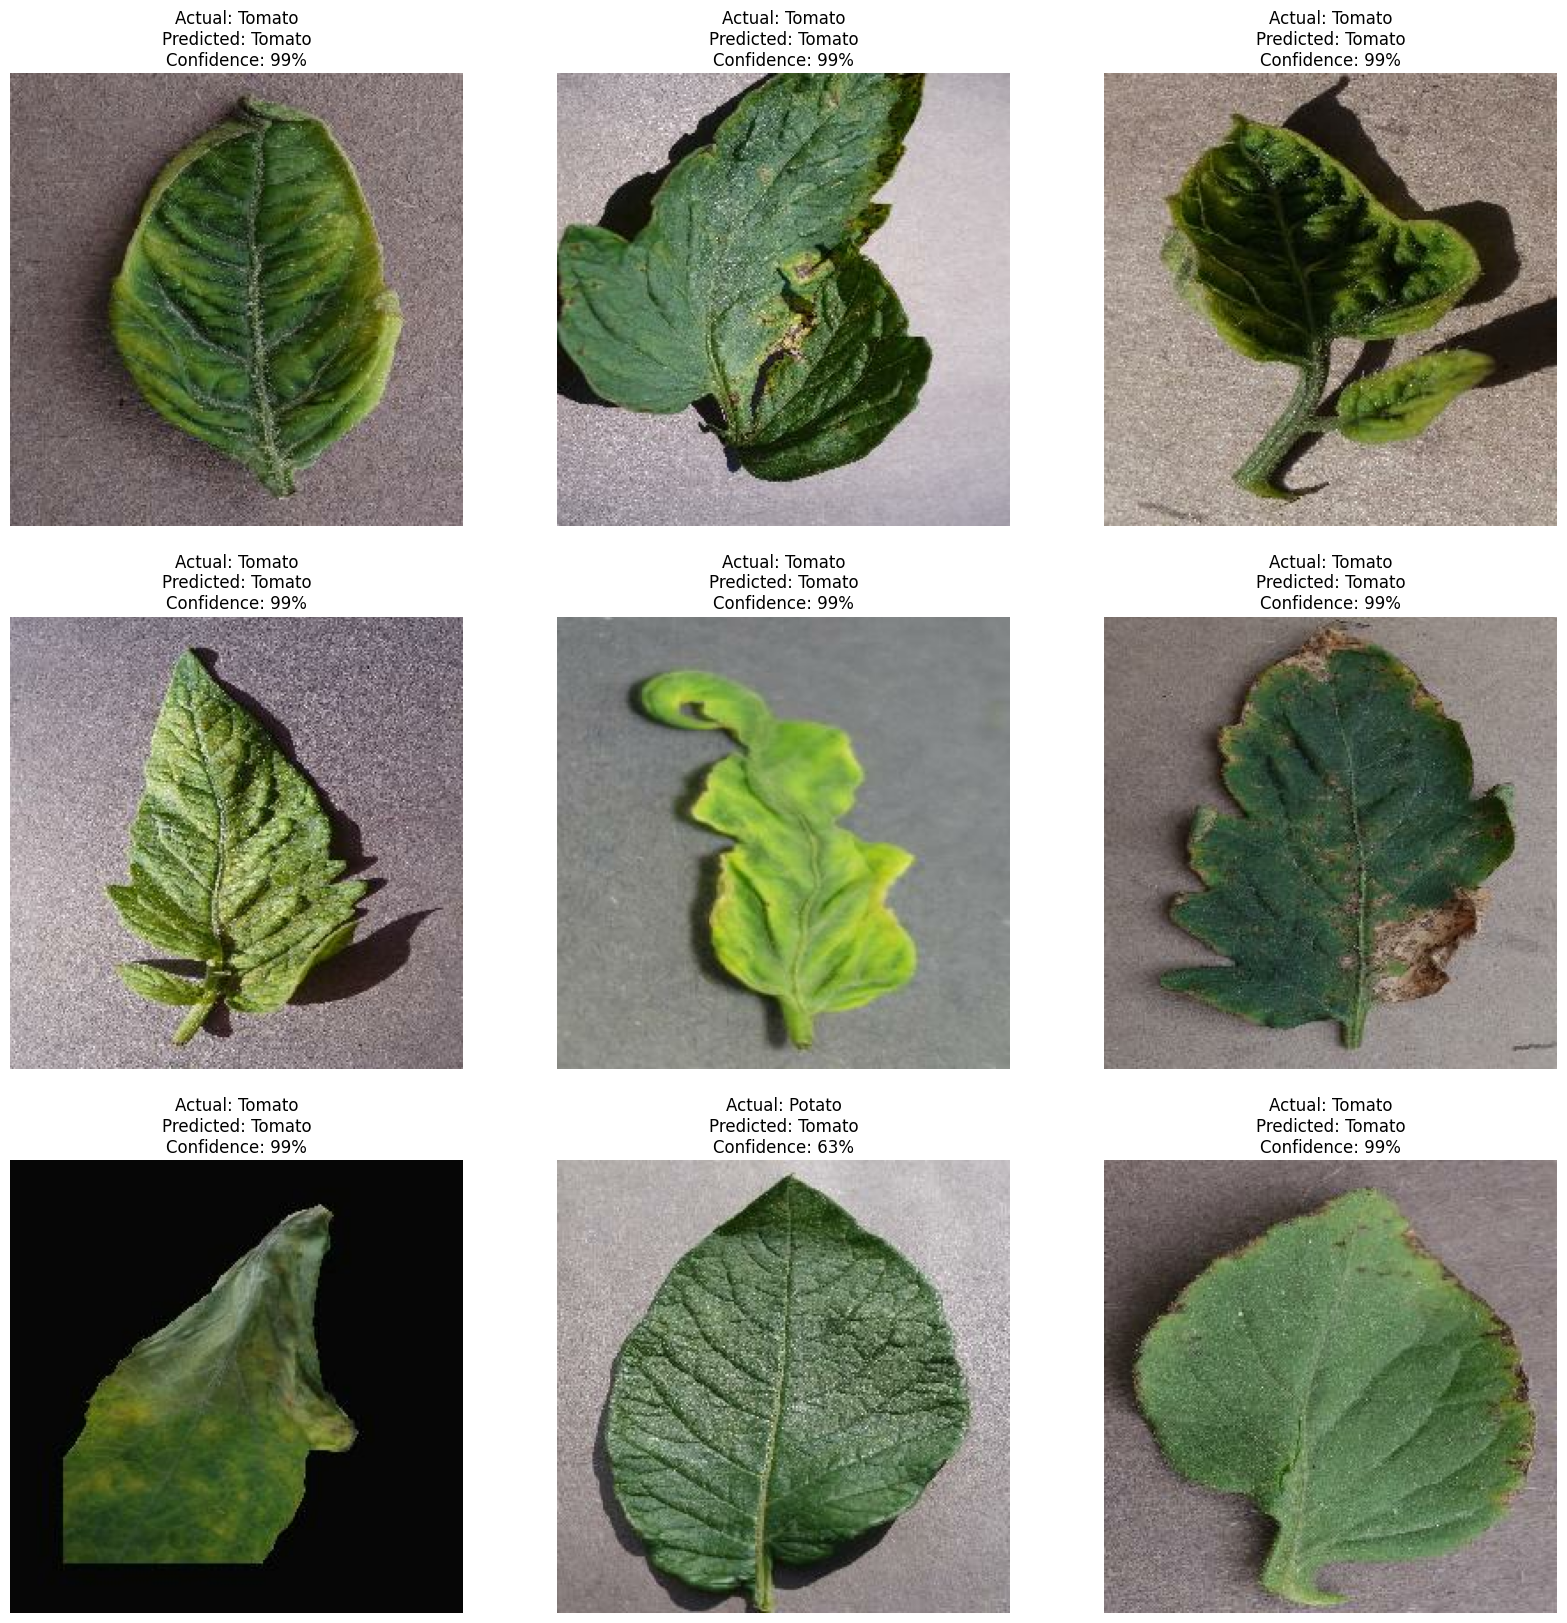

In [38]:
plt.figure(figsize=(20, 20))
for images, labels in test_dataset.take(1):
    for i in range(9):
        predicted_class, confidence = predic_img(model, images)
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        actual_label = dataset.class_names[labels[i]]
        plt.title(
            f"Actual: {actual_label}\nPredicted: {predicted_class}\nConfidence: {int(confidence * 100)}%"
        )
        plt.axis("off")

In [40]:
import os

# import tensorflowjs as tfjs
model_name = "isPata"

versions = os.listdir(f"../models/{model_name}")
versions = [int(v) for v in versions if v.isdigit()]
model_version = max(versions) + 1 if versions else 1
model_version = str(model_version)
model_dir = f"../models/{model_name}/{model_version}"
os.makedirs(model_dir, exist_ok=True)
model.save(f"{model_dir}/model.keras")


In [ ]:
# tfjs.converters.save_keras_model(model, f"{model_dir}/tfjs")
import tensorflow as tf
from tensorflow.keras import models
import os
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import onnxruntime
spec = (tf.TensorSpec(model.input_shape, tf.float32, name="input"),)
import tf2onnx
import onnxruntime as rt

output_path = f"../models/isPata/{model_version}/{model.name}.onnx"
model.output_names = ["output"]
model_proto, _ = tf2onnx.convert.from_keras(
    model, input_signature=spec, opset=13, output_path=output_path
)